# Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

# Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

# План

1. Загрузить 4 датасета и проанализировать содержащиеся в них данные

2. Выполнить предобработку данных

3. Объединить таблицы по ID - клиента

4. Категорильные признаки преобразовать в числовые

8. Выбирать признаки и целевой признак

9. Выделим 20% тестовых данных из всего объема данных

10. Обучить модель и проверить на тестовых данных

11. Проверим модель на тестовых данных. 

12. Вычислить AUC-ROC

# Загрузим и проанализируем датасеты

### Датасет  'contract'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor    
from joblib import Parallel, delayed
from sklearn.datasets import make_classification


#Откроем файл
contract = pd.read_csv('/datasets/final_provider/contract.csv')

#Отобразим первые 5 строк таблицы
display(contract.head(5))

#Отобразим размер таблицы
print('Размер таблицы:')
display(contract.shape)


#Просмотрим общую информации о таблице
print('Общая информация о таблице:')
contract.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Размер таблицы:


(7043, 8)

Общая информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


### Датасет  'personal'

In [2]:
#Откроем файл
personal = pd.read_csv('/datasets/final_provider/personal.csv')

#Отобразим первые 5 строк таблицы
display(personal.head(5))

#Отобразим размер таблицы
print('Размер таблицы:')
display(personal.shape)

#Просмотрим общую информации о таблице
print('Общая информация о таблице:')
personal.info()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Размер таблицы:


(7043, 5)

Общая информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


### Датасет  'internet'

In [3]:
#Откроем файл
internet = pd.read_csv('/datasets/final_provider/internet.csv')

#Отобразим первые 5 строк таблицы
display(internet.head(5))

#Отобразим размер таблицы
print('Размер таблицы:')
display(internet.shape)

#Просмотрим общую информации о таблице
print('Общая информация о таблице:')
internet.info()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Размер таблицы:


(5517, 8)

Общая информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


### Датасет  'phone'

In [4]:
#Откроем файл
phone = pd.read_csv('/datasets/final_provider/phone.csv')

#Отобразим первые 5 строк таблицы
display(phone.head(5))

#Отобразим размер таблицы
print('Размер таблицы:')
display(phone.shape)

#Просмотрим общую информации о таблице
print('Общая информация о таблице:')
phone.info()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Размер таблицы:


(6361, 2)

Общая информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


### Выполним слиение датасета "contract" и 'personal' и потом выполним слияние с датасетом "phone"

In [5]:
#Выполним слиение датасета "contract" и 'personal'
data_1 = contract.merge(personal, on='customerID', how='left')
data_2 = data_1.merge(internet, on='customerID', how='left')
data_full = data_2.merge(phone, on='customerID', how='left')
display(data_full.head(5))
data_full.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
MultipleLines       6361 non-null object
dtypes: float64(1), int64(1), object(18)
memory usage: 1.1+ MB


### Заменим в датасете значения 'Nan'  на 'No'

In [6]:
print('\n До замены Nan но "No"\n')
print(data_full['MultipleLines'].unique())
print(data_full['InternetService'].unique())
print(data_full['OnlineSecurity'].unique())
print(data_full['OnlineBackup'].unique())
print(data_full['DeviceProtection'].unique())
print(data_full['TechSupport'].unique())
print(data_full['StreamingTV'].unique())
print(data_full['StreamingMovies'].unique())
print(data_full['MultipleLines'].unique())

data_full = data_full.fillna('No')

print('\nПосле замены Nan но "No"\n')
print(data_full['MultipleLines'].unique())
print(data_full['InternetService'].unique())
print(data_full['OnlineSecurity'].unique())
print(data_full['OnlineBackup'].unique())
print(data_full['DeviceProtection'].unique())
print(data_full['TechSupport'].unique())
print(data_full['StreamingTV'].unique())
print(data_full['StreamingMovies'].unique())
print(data_full['MultipleLines'].unique())
#display(data_full['MultipleLines'].sort_values(ascending=True).value_counts())


 До замены Nan но "No"

[nan 'No' 'Yes']
['DSL' 'Fiber optic' nan]
['No' 'Yes' nan]
['Yes' 'No' nan]
['No' 'Yes' nan]
['No' 'Yes' nan]
['No' 'Yes' nan]
['No' 'Yes' nan]
[nan 'No' 'Yes']

После замены Nan но "No"

['No' 'Yes']
['DSL' 'Fiber optic' 'No']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']


### Выполним one hot encoding для категориальных признаков

In [7]:
data_full_ohe = pd.get_dummies(data_full, columns=["Type", "PaperlessBilling",'PaymentMethod','gender','Partner','Dependents','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','MultipleLines'], drop_first=True)
display(data_full_ohe.head(3))

,customerID,BeginDate,EndDate,MonthlyCharges,TotalCharges,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
0,7590-VHVEG,2020-01-01,No,29.85,29.85,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,5575-GNVDE,2017-04-01,No,56.95,1889.5,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,53.85,108.15,0,0,0,1,0,...,0,0,0,1,1,0,0,0,0,0


### Заменим значение "No" на актуальную дату базы 

In [8]:
data_full_ohe['EndDate_new'] = data_full_ohe['EndDate'].replace('No', '2020-02-01 00:00:00')
display(data_full_ohe.head(3))

,customerID,BeginDate,EndDate,MonthlyCharges,TotalCharges,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),...,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,EndDate_new
0,7590-VHVEG,2020-01-01,No,29.85,29.85,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,2020-02-01 00:00:00
1,5575-GNVDE,2017-04-01,No,56.95,1889.5,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,2020-02-01 00:00:00
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,53.85,108.15,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,2019-12-01 00:00:00


### Приведем формат столбцов с датами к datetime64.

In [9]:
data_full_ohe["BeginDate"] = pd.to_datetime(data_full_ohe["BeginDate"])
data_full_ohe["EndDate_new"] = pd.to_datetime(data_full_ohe["EndDate_new"])
data_full_ohe.info()
#data_full_ohe['months'] = (data_full_ohe.EndDate - data_full_ohe.BeginDate)/ np.timedelta64(1, 'M')
data_full_ohe['months_end'] = data_full_ohe['EndDate_new'].dt.month 
display(data_full_ohe.head(3))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 25 columns):
customerID                               7043 non-null object
BeginDate                                7043 non-null datetime64[ns]
EndDate                                  7043 non-null object
MonthlyCharges                           7043 non-null float64
TotalCharges                             7043 non-null object
SeniorCitizen                            7043 non-null int64
Type_One year                            7043 non-null uint8
Type_Two year                            7043 non-null uint8
PaperlessBilling_Yes                     7043 non-null uint8
PaymentMethod_Credit card (automatic)    7043 non-null uint8
PaymentMethod_Electronic check           7043 non-null uint8
PaymentMethod_Mailed check               7043 non-null uint8
gender_Male                              7043 non-null uint8
Partner_Yes                              7043 non-null uint8
Dependents_Yes           

,customerID,BeginDate,EndDate,MonthlyCharges,TotalCharges,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),...,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,EndDate_new,months_end
0,7590-VHVEG,2020-01-01,No,29.85,29.85,0,0,0,1,0,...,0,0,1,0,0,0,0,0,2020-02-01,2
1,5575-GNVDE,2017-04-01,No,56.95,1889.5,0,1,0,0,0,...,0,1,0,1,0,0,0,0,2020-02-01,2
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,53.85,108.15,0,0,0,1,0,...,0,1,1,0,0,0,0,0,2019-12-01,12


### Заменим пустые значения в столбце 'TotalCharges' из удалим нулевые значения из 'TotalCharges'

In [10]:
data_full_ohe['TotalCharges'] = data_full_ohe['TotalCharges'].replace(' ', '0')
data_full_ohe['TotalCharges'] = data_full_ohe['TotalCharges'].astype(float)
data_full_ohe = data_full_ohe.query("TotalCharges != 0")
data_full_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 26 columns):
customerID                               7032 non-null object
BeginDate                                7032 non-null datetime64[ns]
EndDate                                  7032 non-null object
MonthlyCharges                           7032 non-null float64
TotalCharges                             7032 non-null float64
SeniorCitizen                            7032 non-null int64
Type_One year                            7032 non-null uint8
Type_Two year                            7032 non-null uint8
PaperlessBilling_Yes                     7032 non-null uint8
PaymentMethod_Credit card (automatic)    7032 non-null uint8
PaymentMethod_Electronic check           7032 non-null uint8
PaymentMethod_Mailed check               7032 non-null uint8
gender_Male                              7032 non-null uint8
Partner_Yes                              7032 non-null uint8
Dependents_Yes          

### Напишем функцию, которая заменит значения 'No' на 0, а значения с датой на '1' в столбце 'EndDate'

In [11]:
status_1 = '1'
status_0 = '0'
def status(row):
    enddate = row['EndDate']
    if enddate == 'No':
            return status_0    
    return status_1

#Применим функцию к столбцу user_score
data_full_ohe['EndDate']  = data_full_ohe.apply(status, axis=1)
display(data_full_ohe.head(3))
data_full_ohe['EndDate'] = data_full_ohe['EndDate'].astype(int)
data_full_ohe.info()

,customerID,BeginDate,EndDate,MonthlyCharges,TotalCharges,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),...,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,EndDate_new,months_end
0,7590-VHVEG,2020-01-01,0,29.85,29.85,0,0,0,1,0,...,0,0,1,0,0,0,0,0,2020-02-01,2
1,5575-GNVDE,2017-04-01,0,56.95,1889.50,0,1,0,0,0,...,0,1,0,1,0,0,0,0,2020-02-01,2
2,3668-QPYBK,2019-10-01,1,53.85,108.15,0,0,0,1,0,...,0,1,1,0,0,0,0,0,2019-12-01,12


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 26 columns):
customerID                               7032 non-null object
BeginDate                                7032 non-null datetime64[ns]
EndDate                                  7032 non-null int64
MonthlyCharges                           7032 non-null float64
TotalCharges                             7032 non-null float64
SeniorCitizen                            7032 non-null int64
Type_One year                            7032 non-null uint8
Type_Two year                            7032 non-null uint8
PaperlessBilling_Yes                     7032 non-null uint8
PaymentMethod_Credit card (automatic)    7032 non-null uint8
PaymentMethod_Electronic check           7032 non-null uint8
PaymentMethod_Mailed check               7032 non-null uint8
gender_Male                              7032 non-null uint8
Partner_Yes                              7032 non-null uint8
Dependents_Yes           

### Выделим признаки и проверим на мультиколлинеарность

In [12]:
features= data_full_ohe.drop(['customerID', 'BeginDate', 'EndDate', 'EndDate_new','months_end'], axis=1)

def calculate_vif_(X, thresh=5.0):
    variables = [X.columns[i] for i in range(X.shape[1])]
    dropped=True
    while dropped:
        dropped=False
        print(len(variables))
        vif = Parallel(n_jobs=-1,verbose=5)(delayed(variance_inflation_factor)(X[variables].values, ix) for ix in range(len(variables)))

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print(time.ctime() + ' dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables.pop(maxloc)
            dropped=True

    print('Remaining variables:')
    print([variables])
    return X[[i for i in variables]]

X = features

X2 = calculate_vif_(X,5)

21


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


Thu Jul  8 14:18:13 2021 dropping 'MonthlyCharges' at index: 0
20


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


Thu Jul  8 14:18:16 2021 dropping 'TotalCharges' at index: 0
19


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s


Remaining variables:
[['SeniorCitizen', 'Type_One year', 'Type_Two year', 'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes', 'MultipleLines_Yes']]


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.8s finished


### Выделим признаки и целевой признак для модели. Удалим из признаков 'TotalCharges' в связи с мультиколлинеарностью с 'MonthlyCharges'.  Разделим данные на тренировочные, валидационные и тестовые. 

In [13]:
target_forest= data_full_ohe['EndDate']
features_forest= data_full_ohe.drop(['customerID', 'TotalCharges','BeginDate', 'EndDate', 'EndDate_new','months_end'], axis=1)

#Выделим 20% тестовых данных из всего объема данных
features_df1, features_test_forest, target_df1, target_test_forest = train_test_split(features_forest, target_forest, test_size=0.20, random_state=12345)

#Разделим отавшиеся 80% данных на тренировочные и валидационные(проверечное). Данные делим в пропорции: 75% от общего числа
#данных - это тренировочные, 25% от общего числа - это валидационные.
features_train_forest, features_valid_forest, target_train_forest, target_valid_forest = train_test_split(features_df1, target_df1, test_size=0.25, random_state=12345)

In [14]:
features_forest

,MonthlyCharges,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
0,29.85,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0
1,56.95,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0
2,53.85,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0
3,42.30,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0
4,70.70,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,84.80,0,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,1
7039,103.20,0,1,0,1,1,0,0,0,1,1,1,0,0,1,1,0,1,1,1
7040,29.60,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0
7041,74.40,1,0,0,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1


### Построим график важности признаков

Automatically created module for IPython interactive environment
Elapsed time to compute the importances: 0.002 seconds


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


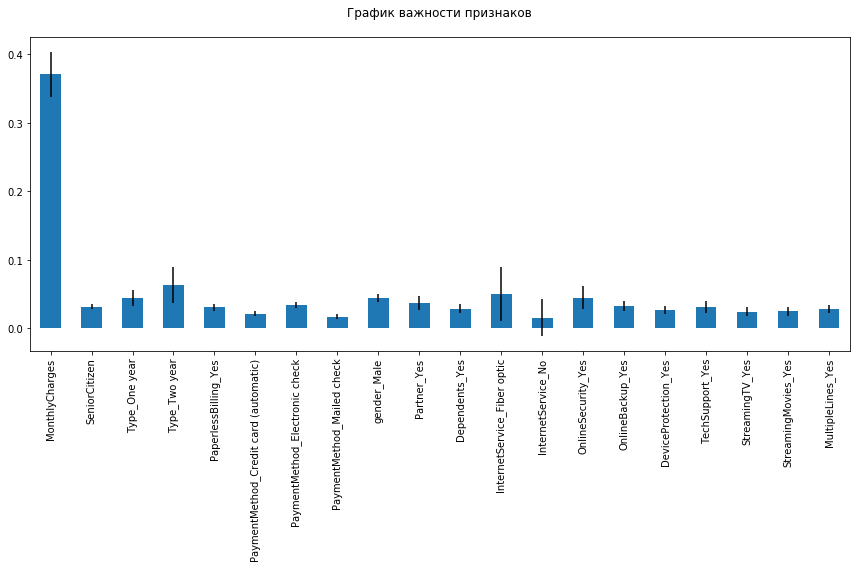

In [15]:
%matplotlib inline
print(__doc__)
X, y = make_classification(
    n_samples=1000, n_features=20, n_informative=3, n_redundant=0,
    n_repeated=0, n_classes=2, random_state=0, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(
    features_forest, target_forest, stratify=target_forest, random_state=42)

feature_names = [f'feature {i}' for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

start_time = time.time()
importances = forest.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

feature_names = features_forest.columns
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax, figsize=(12,8))
ax.set_title("График важности признаков\n")
fig.tight_layout()

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
ОТЛИЧНО, что удаляешь факторы-даты!!!!! Если у нас тема НЕ временные ряды, то такие факторы лучше не использовать. Они "нагонят" метрики, но бизнес-эффективность модели  - рухнет.

### Напишем функцию для модели 'случайный лес', чтобы выбрать лучшую модель

In [16]:
# Напишем функцию для модели 'случайный лес', чтобы выбрать лучшую модель в зависимости от количества деревьев.
rfc = RandomForestClassifier()
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(features_train_forest, target_train_forest)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.9min finished


{'n_estimators': 556,
 'min_samples_split': 23,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 15,
 'bootstrap': False}

### Вычислим AUC-ROC для модели Случайный лес

In [17]:
#Вычислим AUC-ROC
model = RandomForestClassifier(bootstrap = 'False', random_state=12345, max_depth=15, n_estimators=556, min_samples_split=23, min_samples_leaf=2, max_features = 'sqrt')
model.fit(features_train_forest, target_train_forest)
probabilities_valid = model.predict_proba(features_test_forest)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_test_forest, probabilities_one_valid)
print('AUC-ROC модели случайный лес:', auc_roc)

AUC-ROC модели случайный лес: 0.8194302790469973


### Построим график AUC-ROC для модели Случайный лес

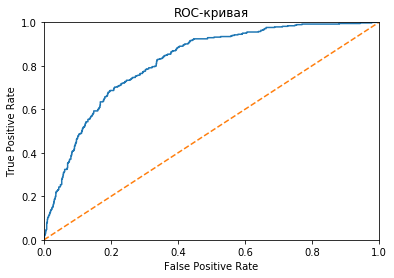

In [18]:
fpr, tpr, thresholds = roc_curve(target_test_forest, probabilities_one_valid) 

#Построим график AUC-ROC
plt.figure()
plt.plot(fpr, tpr)

#ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

#Примените функции plt.xlim() и plt.ylim(), чтобы установить границы осей от 0 до 1 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

#Примените функции plt.xlabel() и plt.ylabel(), чтобы одписать оси "False Positive Rate" и "True Positive Rate" 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#Добавим к графику заголовок "ROC-кривая" функцией plt.title()
plt.title('ROC-кривая')
plt.show()